In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

Goals with this EDA
- Look at which species are most common and least common
- geographical distribution of recordings, recorders and species
- different sources for recordings and how often they produce certain quality of recordings
- different noises birds make, calls vs songs
- raining, windy etc. Does this affect ability to distinguish species

Modelling Goals
- Use Lat/Lon along with satelittle data to determine habitat, elevation, land use
- create classifier using some common species to distinguish weather conditions, rain, wind, chainsaw etc.
- Use CNN to create features and potentially other model for classification

In [11]:
train = pd.read_csv('../data/train.csv')
taxonomy = pd.read_csv('../data/taxonomy.csv')

In [10]:
train.info()
taxonomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28564 entries, 0 to 28563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     28564 non-null  object 
 1   secondary_labels  28564 non-null  object 
 2   type              28564 non-null  object 
 3   filename          28564 non-null  object 
 4   collection        28564 non-null  object 
 5   rating            28564 non-null  float64
 6   url               28564 non-null  object 
 7   latitude          27755 non-null  float64
 8   longitude         27755 non-null  float64
 9   scientific_name   28564 non-null  object 
 10  common_name       28564 non-null  object 
 11  author            28564 non-null  object 
 12  license           28564 non-null  object 
dtypes: float64(3), object(10)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 5 columns):
 #   Column           Non-Nul

In [21]:
print(train['primary_label'].nunique())
print(train['primary_label'].value_counts().head(20))

206
primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
soulap1    487
sobtyr1    478
trsowl     470
laufal1    467
strcuc1    431
bbwduc     424
saffin     419
amekes     409
tropar     397
compot1    383
Name: count, dtype: int64


In [25]:
species_info = train[['primary_label', 'common_name', 'scientific_name']].drop_duplicates()
species_info = species_info.sort_values('primary_label').reset_index(drop=True)
print(species_info)

    primary_label                   common_name               scientific_name
0         1139490          Ragoniella pulchella          Ragoniella pulchella
1         1192948         Oxyprora surinamensis         Oxyprora surinamensis
2         1194042           Copiphora colombiae           Copiphora colombiae
3          126247        Spotted Foam-nest Frog       Leptodactylus insularum
4         1346504  Neoconocephalus brachypterus  Neoconocephalus brachypterus
..            ...                           ...                           ...
201       yehcar1        Yellow-headed Caracara            Milvago chimachima
202       yelori1                 Yellow Oriole          Icterus nigrogularis
203       yeofly1       Yellow-olive Flycatcher      Tolmomyias sulphurescens
204       yercac1         Yellow-rumped Cacique                  Cacicus cela
205        ywcpar         Yellow-crowned Parrot          Amazona ochrocephala

[206 rows x 3 columns]


In [27]:
print(train['secondary_labels'].nunique())
print(train['secondary_labels'].value_counts().head(20))

745
secondary_labels
['']           25885
['grekis']       254
['whtdov']       165
['trokin']        83
['banana']        63
['soulap1']       59
['saffin']        58
['rugdov']        51
['yercac1']       44
['pirfly1']       42
['blbgra1']       37
['bugtan']        35
['compau']        35
['socfly1']       35
['bubwre1']       35
['cotfly1']       33
['chbant1']       32
['tropar']        30
['yebela1']       30
['rutjac1']       29
Name: count, dtype: int64


In [26]:
print(train['type'].nunique())
print(train['type'].value_counts().head(20))

736
type
['song']                           9437
['']                               8099
['call']                           5746
['call', 'song']                   1088
['flight call']                     804
['alarm call']                      346
['call', 'calls']                   178
['dawn song']                       170
['uncertain']                       168
['call', 'flight call']             163
['flight call', 'song']             117
['drumming']                        104
['duet']                             98
['alarm call', 'call']               94
['duet', 'song']                     91
['canto']                            73
['begging call']                     68
['flight call', 'flight calls']      55
['alarm call', 'flight call']        55
['nocturnal flight call']            48
Name: count, dtype: int64


Separate out the combinations of what were observed in the recording
Create one hot columns for 'call', 'song' etc.

Create new columns for rainy, windy and maybe also night vs day because of the crickets and other creatures
Maybe look in to if the label 'dawn song' or 'nocturnal flight call' is used automatically putting them in to day or night

Also chainsaw noises. Maybe I can manually label some of the data and create a classifier for those if they cause too much disturbance

In [28]:
print(train['collection'].nunique())
print(train['collection'].value_counts().head(20))

3
collection
XC      21204
iNat     7198
CSA       162
Name: count, dtype: int64


In [29]:
print(train['rating'].nunique())
print(train['rating'].value_counts().head(20))

11
rating
0.0    7948
4.0    7582
5.0    6556
3.0    2886
4.5    1261
3.5     895
2.0     752
2.5     360
1.0     228
1.5      70
0.5      26
Name: count, dtype: int64


In [30]:
print(train['author'].nunique())
print(train['author'].value_counts().head(20))


2493
author
JAYRSON ARAUJO DE OLIVEIRA                                                            1780
Unknown                                                                               1612
Bernabe Lopez-Lanus                                                                    768
Jerome Fischer                                                                         743
Dante Buzzetti                                                                         562
Niels Krabbe                                                                           558
Jeremy Minns                                                                           522
GABRIEL LEITE                                                                          515
Fernando Igor de Godoy                                                                 468
Richard E. Webster                                                                     438
Manuel Grosselet                                                              

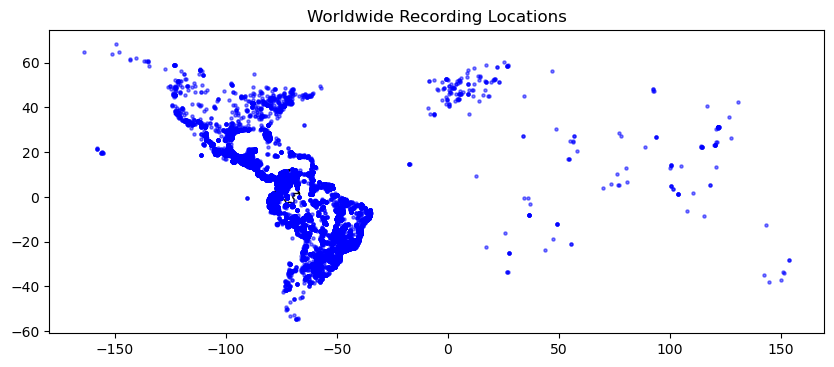

In [52]:
world = gpd.read_file(Path('../110m_cultural') / 'ne_110m_admin_0_countries.shp')

# Filter for Colombia
colombia = world[world['NAME'] == 'Colombia'].copy()  # .copy() avoids SettingWithCopyWarning

# Your points data
geo_df = train.dropna(subset=['latitude', 'longitude'])
gdf = gpd.GeoDataFrame(
    geo_df, 
    geometry=gpd.points_from_xy(geo_df.longitude, geo_df.latitude),
    crs=world.crs  # Match CRS with the world map
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
colombia.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, markersize=5, color='blue', alpha=0.5)
plt.title("Worldwide Recording Locations")
plt.show()

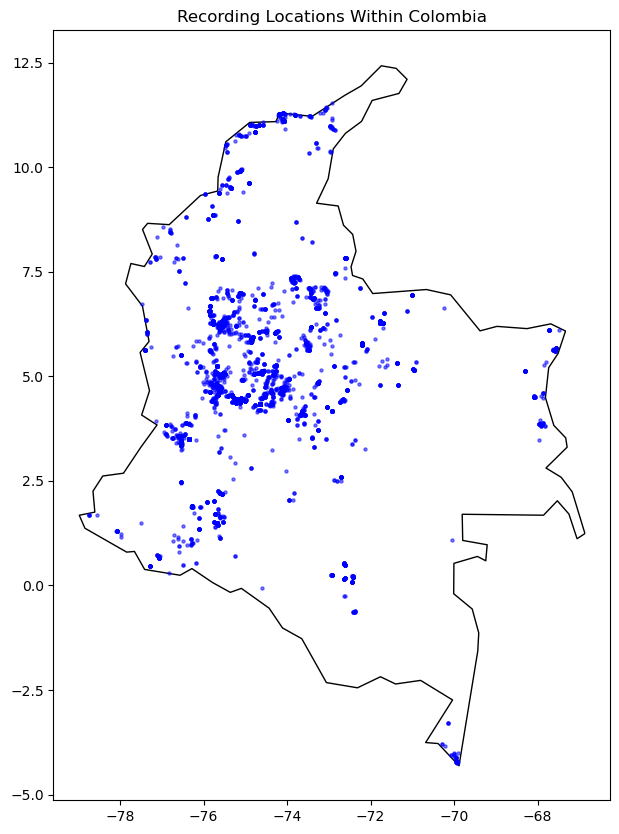

In [53]:
gdf = gdf.set_crs("EPSG:4326", allow_override=True)
colombia = colombia.to_crs("EPSG:4326")

gdf_clipped = gdf.clip(colombia)

fig, ax = plt.subplots(figsize=(10, 10))
colombia.plot(ax=ax, color='white', edgecolor='black')
gdf_clipped.plot(ax=ax, markersize=5, color='blue', alpha=0.5)
plt.title("Recording Locations Within Colombia")
plt.show()
